https://github.com/gbrammer/msaexp/

https://github.com/gbrammer/msaexp/blob/d10a7e94e157dfb7b99b9016c50b20b709b41b6b/msaexp/msa.py#L191

see example code in class MSAMetafile: ### Make a plot with slitlets

In [1]:
import os
import glob
import yaml
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('https://www.stsci.edu/~dcoe/matplotlibrc.txt')
%matplotlib inline

import PIL
from PIL import Image, ImageEnhance
PIL.Image.MAX_IMAGE_PIXELS = 933120000  # allow it to load large image

import grizli
from grizli import utils, jwst_utils
jwst_utils.set_quiet_logging()
utils.set_warnings()

import astropy
import astropy.io.fits as pyfits
from astropy.io import fits
import astropy.wcs as wcs
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table

from jwst.datamodels import SlitModel

import msaexp
from msaexp import pipeline, msa

print(f'msaexp version = {msaexp.__version__}')
print(f'grizli version = {grizli.__version__}')
print(f'matplotlib version = {matplotlib.__version__}')
print(f'astropy version = {astropy.__version__}')

msaexp version = 0.6.0
grizli version = 1.7.5
matplotlib version = 3.7.0
astropy version = 5.2.1


In [2]:
def roundint(x):
    return int(np.round(x))

def slices_extent(x, y, dx, dy=0):
    dy = dy or dx
    xlo = roundint(x-dx)
    xhi = roundint(x+dx+1)
    ylo = roundint(y-dy)
    yhi = roundint(y+dy+1)
    xslice = slice(xlo, xhi)
    yslice = slice(ylo, yhi)
    slices = yslice, xslice
    extent = xlo, xhi, ylo, yhi
    return slices, extent

In [3]:
prog = 1433
outroot = 'macs0647'
file_version = 'v1'
os.getcwd()

'/Users/dcoe/macs0647/MSA/dataObs23'

In [4]:
# Query NIRSpec data for a program name
masks = pipeline.query_program(prog, download=True)

In [5]:
files = glob.glob(f'jw0{prog}*rate.fits')

groups = pipeline.exposure_groups(files=files)

print('\nFiles:\n======')
print(yaml.dump(dict(groups)))

   N  value     
====  ==========
   1  jw01433021001-01-clear-prism-nrs1
   1  jw01433021001-01-clear-prism-nrs2
   1  jw01433021001-02-clear-prism-nrs1
   1  jw01433021001-02-clear-prism-nrs2
   3  jw01433023001-01-clear-prism-nrs1
   3  jw01433023001-01-clear-prism-nrs2

Files:
jw01433021001-01-clear-prism-nrs1:
- jw01433021001_03101_00001_nrs1_rate.fits
jw01433021001-01-clear-prism-nrs2:
- jw01433021001_03101_00001_nrs2_rate.fits
jw01433021001-02-clear-prism-nrs1:
- jw01433021001_05101_00001_nrs1_rate.fits
jw01433021001-02-clear-prism-nrs2:
- jw01433021001_05101_00001_nrs2_rate.fits
jw01433023001-01-clear-prism-nrs1:
- jw01433023001_04101_00002_nrs1_rate.fits
- jw01433023001_04101_00003_nrs1_rate.fits
- jw01433023001_04101_00001_nrs1_rate.fits
jw01433023001-01-clear-prism-nrs2:
- jw01433023001_04101_00001_nrs2_rate.fits
- jw01433023001_04101_00002_nrs2_rate.fits
- jw01433023001_04101_00003_nrs2_rate.fits



In [6]:
pipe = pipeline.NirspecPipeline(mode='jw01433023001-01-clear-prism-nrs1') 

# (2023-05-05 19:23:16.562)
msaexp.NirspecPipeline: Initialize jw01433023001-01-clear-prism-nrs1
msaexp.NirspecPipeline: jw01433023001_04101_00001_nrs1_rate.fits
msaexp.NirspecPipeline: jw01433023001_04101_00002_nrs1_rate.fits
msaexp.NirspecPipeline: jw01433023001_04101_00003_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw01433023001-01-clear-prism-nrs1 msametfl=jw01433023001_01_msa.fits


In [7]:
meta = msa.MSAMetafile('jw01433023001_01_msa.fits')

In [8]:
cosd = np.cos(np.median(meta.src_table['dec'])/180*np.pi)

In [9]:
meta.src_table[:2]  # show first few rows

program,source_id,source_name,alias,ra,dec,preimage_id,stellarity
int32,int32,str20,str31,float64,float64,str30,float64
1433,731,1433_731,731,101.914529,70.193369,None,-1.0
1433,756,1433_756,756,101.890665,70.193726,None,-1.0


# Load color image

In [10]:
color_image_file = '/Users/dcoe/macs0647/v5/color/macs0647_color.png'
im = Image.open(color_image_file)
im = im.transpose(method=Image.FLIP_TOP_BOTTOM)
color_image = np.asarray(im)

2023-05-05 15:23:16,927 - stpipe - WARNING - /var/folders/y3/vsjr6j554mnfpgy_m1xrnckm0003tz/T/ipykernel_28032/370765965.py:3: DeprecationWarning: FLIP_TOP_BOTTOM is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_TOP_BOTTOM instead.
  im = im.transpose(method=Image.FLIP_TOP_BOTTOM)



In [11]:
from glob import glob
fits_image_file = glob('/Users/dcoe/macs0647/v5/images/20mas/*.fits')[-1]
fits_image_file  # for RA, Dec -> x, y

'/Users/dcoe/macs0647/v5/images/20mas/macs0647-f150w-clear_drc_sci.fits'

In [12]:
hdu = fits.open(fits_image_file)
idata = 0
image_wcs = wcs.WCS(hdu[idata].header, hdu)
image_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 102.01309126412  70.228213113066  
CRPIX : 9321.0  9128.0  
CD1_1 CD1_2  : -5.5555555555555e-06  0.0  
CD2_1 CD2_2  : 0.0  5.5555555555555e-06  
NAXIS : 18640  18254

# Extract and plot NIRSpec slitlets

In [13]:
def plot_slitlets(id, name, obsnum=23, save_plot=False):
    slitlets_radec = []

    slits = meta.regions_from_metafile(dither_point_index=1, as_string=False, with_bars=True)
    for s in slits:
        if s.meta['source_id'] in [id]:
            radec = s.xy[0]
            slitlets_radec.append(radec)
            ra, dec = radec.T
            slit_coordinates = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
            xy = x, y = image_wcs.world_to_pixel(slit_coordinates)
            #print('x = ', x)
            #print('y = ', y)
            if s.meta['is_source']:
                slices, extent = slices_extent(np.mean(x), np.mean(y), 50)

    fig = plt.figure(figsize=(9.5, 6))
    ax = fig.add_subplot(1, 1, 1) #, projection=imwcs) # , sharex=True, sharey=True)
    ax.imshow(color_image[slices], extent=extent) #, origin='lower')

    for radec in slitlets_radec:
        ra, dec = radec.T
        slit_coordinates = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
        xy = x, y = image_wcs.world_to_pixel(slit_coordinates)
        xy = np.array(xy).T  # (4, 2)
        #print(np.mean(x), np.mean(y))
        patch = matplotlib.patches.Polygon(xy, fc='None', ec='r', alpha=1, zorder=100)
        ax.add_patch(patch)

    label = name + ' #%d' % id
    plt.text(0.05, 0.95, label, color='w', fontsize=36, fontweight='bold', va='top', transform=ax.transAxes)

    label = 'Obs %d' % obsnum
    plt.text(0.05, 0.05, label, color='w', fontsize=36, fontweight='bold', transform=ax.transAxes)

    ax.axis('off')
    
    if save_plot:
        outfile = 'slitlets_%d_Obs%d.pdf' % (id, obsnum)
        plt.savefig(outfile, bbox_inches='tight', dpi=800)
        
    plt.show()

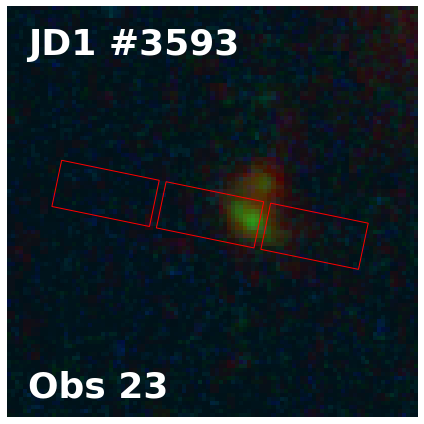

In [14]:
plot_slitlets(3593, 'JD1', obsnum=23)

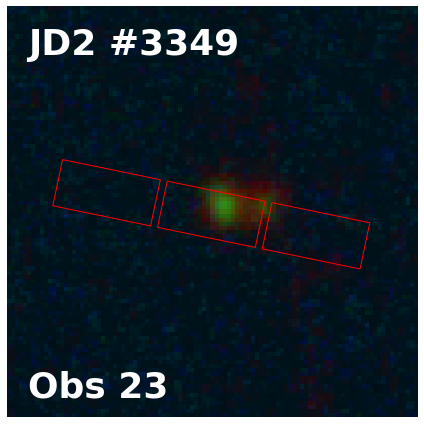

In [15]:
plot_slitlets(3349, 'JD2', obsnum=23)

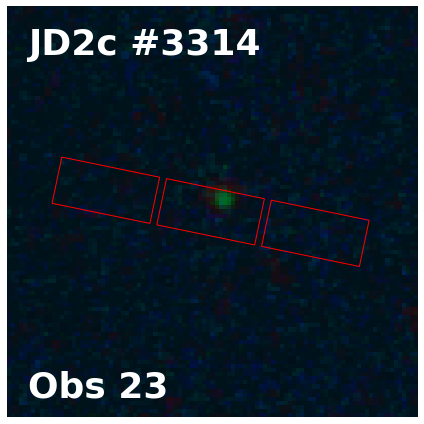

In [16]:
plot_slitlets(3314, 'JD2c', obsnum=23)

# Observation 21

In [17]:
pipe = pipeline.NirspecPipeline(mode='jw01433021001-02-clear-prism-nrs2') 

# (2023-05-05 19:23:26.180)
msaexp.NirspecPipeline: Initialize jw01433021001-02-clear-prism-nrs2
msaexp.NirspecPipeline: jw01433021001_05101_00001_nrs2_rate.fits
msaexp.NirspecPipeline: mode=jw01433021001-02-clear-prism-nrs2 msametfl=jw01433021001_02_msa.fits


In [18]:
meta = msa.MSAMetafile(pipe.msametfl)

In [19]:
meta.src_table[:2]  # show first few rows

program,source_id,source_name,alias,ra,dec,preimage_id,stellarity
int32,int32,str20,str31,float64,float64,str30,float64
1433,2883,1433_2883,2883,101.968846,70.229727,None,-1.0
1433,2901,1433_2901,2901,101.956138,70.23049,None,-1.0


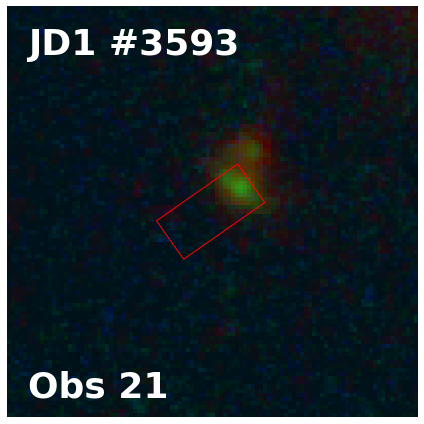

In [20]:
plot_slitlets(3593, 'JD1', obsnum=21)

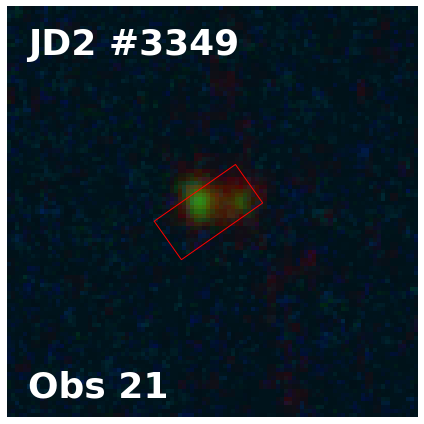

In [21]:
plot_slitlets(3349, 'JD2', obsnum=21)

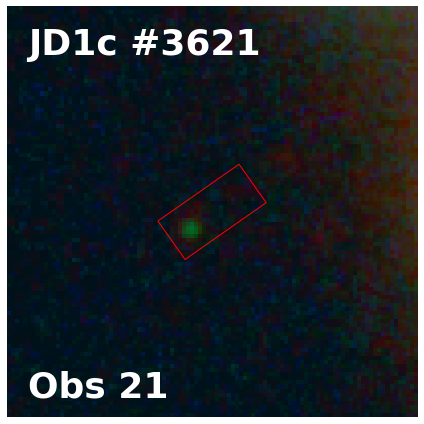

In [22]:
plot_slitlets(3621, 'JD1c', obsnum=21)